In [1]:
import emcee
import arviz as az

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import time
import jax.numpy as jnp
from functions.distributions import log_gaussian_2d

class MetropolisHastings:
    def __init__(self, target_distr, initial_state=None, seed=None):
        """
        Initialize the Metropolis-Hastings sampler.
        
        Parameters:
        - target_distr: function
            The target distribution from which we want to sample.
        - initial_state: array-like, optional
            The initial state of the Markov chain. Default is a zero vector.
        - seed: int, optional
            Random seed for reproducibility. Default is None.
        """
        self.target_distr = target_distr
        self.dim = len(initial_state) if initial_state is not None else 1
        self.initial_state = np.array(initial_state) if initial_state is not None else np.zeros(self.dim)
        self.seed = seed
        self.samples = []
        self.acceptance_rate = 0.0
        self.mean = None
        self.covariance = None
        self.time = 0.0
        
        if seed is not None:
            np.random.seed(seed)
    
    def sample(self, n_samples):
        """
        Generate samples using the Metropolis-Hastings algorithm.
        
        Parameters:
        - n_samples: int
            The number of samples to generate.
        
        Returns:
        - samples: np.array
            Array of generated samples.
        """
        start_time = time.time()
        
        proposal_distr = scipy.stats.multivariate_normal
        # Random covariance matrix for the proposal distribution
        A = np.random.rand(self.dim, self.dim)
        cov = np.dot(A, A.T)
        
        x_t = self.initial_state
        samples = []
        accept_count = 0
        
        while len(samples) < n_samples:
            x_prime = proposal_distr.rvs(mean=x_t, cov=cov)
            acceptance_ratio = (self.target_distr(x_prime) * proposal_distr.pdf(x_t, mean=x_prime, cov=cov)) / \
                               (self.target_distr(x_t) * proposal_distr.pdf(x_prime, mean=x_t, cov=cov))
            
            acceptance_ratio = min(1, acceptance_ratio)
            if np.random.uniform(0, 1) < acceptance_ratio:
                x_t = x_prime
                samples.append(x_t)
                accept_count += 1
            else:
                samples.append(x_t)
        
        self.samples = np.array(samples)
        self.acceptance_rate = accept_count / n_samples
        self.mean = np.mean(self.samples, axis=0)
        self.covariance = np.cov(self.samples.T)
        
        self.time = time.time() - start_time
        
        return self.samples

2D Gaussian Analysis of Metropolis Hasting

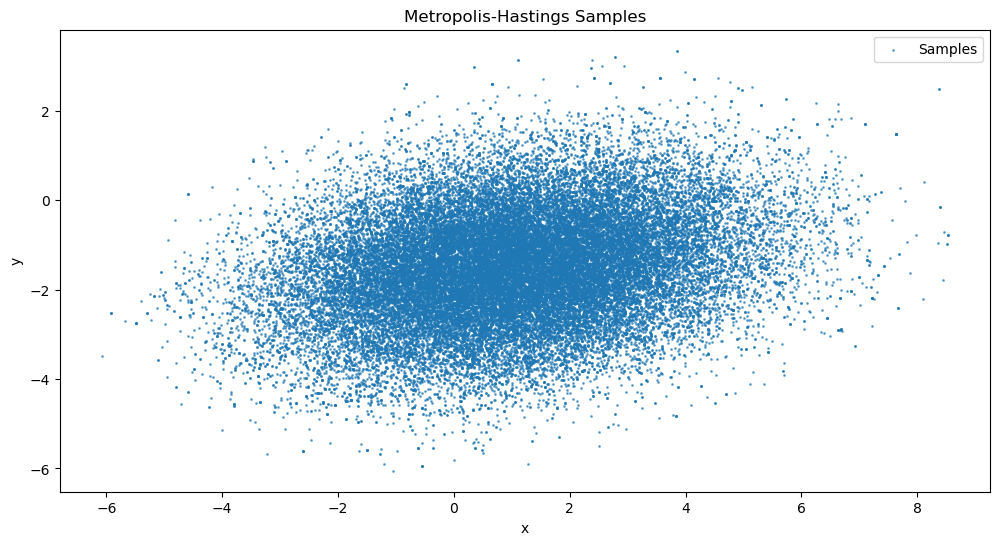

In [3]:
# Define the target distribution: a 2D Gaussian
def target_distribution(x):
    mean = np.array([1, -1.5])
    cov = np.array([[4, 0.7], [0.7, 1.5]])
    return scipy.stats.multivariate_normal.pdf(x, mean=mean, cov=cov)

# Initialize the Metropolis-Hastings sampler
initial_state = np.zeros(2)
MH_sampler_2D = MetropolisHastings(target_distribution, initial_state, seed=42)

# Generate samples
n_samples = 50000
samples = MH_sampler_2D.sample(n_samples)

# Define the true distribution for plotting
mean = np.array([1, -1.5])
cov = np.array([[4, 0.7], [0.7, 1.5]])
rv = scipy.stats.multivariate_normal(mean, cov)

# Create a grid for plotting the true distribution
x, y = np.mgrid[-5:7:.1, -6:3:.1]
pos = np.dstack((x, y))

# Plotting
plt.figure(figsize=(12, 6))

# Plot the sampled points
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, marker='o', s=1, label='Samples')
plt.title('Metropolis-Hastings Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()


In [4]:
ac = emcee.autocorr.integrated_time(samples)
print(ac)

[46.71117045]


15D Gaussian Analysis of Metropolis Hasting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the target distribution: a multivariate Gaussian shifted from zero with some correlation
mean = np.ones(15)  # Mean is shifted from zero
cov = np.eye(15) * 0.5 + 0.5  # Correlated covariance matrix

def target_distribution(x):
    return scipy.stats.multivariate_normal.pdf(x, mean=mean, cov=cov)

# Initialize the Metropolis-Hastings sampler
initial_state = np.zeros(15)
MH_sampler_15D = MetropolisHastings(target_distr=target_distribution, initial_state=initial_state, seed=42)

# Generate 10,000 samples
samples = MH_sampler_15D.sample(50000)

# Print the results
print("Acceptance Rate:", MH_sampler_15D.acceptance_rate)
print("Mean of the Samples:\n", MH_sampler_15D.mean)
print("Covariance Matrix of the Samples:\n", MH_sampler_15D.covariance)
print("Sampling Time:", MH_sampler_15D.time, "seconds")

# Plotting the mean of the samples
plt.figure(figsize=(10, 6))
plt.plot(MH_sampler_15D.mean, 'o-', label='Sample Mean')
plt.plot(mean, 'x-', label='True Mean')
plt.legend()
plt.title("Sample Mean vs True Mean")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.show()


In [ ]:
# Define the initial points for the four chains
initial_states = [
    np.zeros(15),
    np.ones(15) * 0.5,
    np.ones(15) * -0.5,
    np.ones(15)
]

n_samples = 50000  # Number of samples per chain
seed = 42  # Seed for reproducibility

# Create and sample from 4 chains with different initial points
chains = []
for i, initial_state in enumerate(initial_states):
    mh_sampler = MetropolisHastings(target_distr=target_distribution, initial_state=initial_state, seed=seed + i)
    samples = mh_sampler.sample(n_samples)
    chains.append(samples)

# Convert the list of chains to a format suitable for ArviZ
chains = np.array(chains)

# Calculate the R-hat value using ArviZ
idata = az.convert_to_inference_data(chains)
rhat = az.rhat(idata)

print(f"R-hat values:\n{rhat}")

In [ ]:
# Plot trace
az.plot_trace(idata)
plt.show()

# Plot autocorrelation
az.plot_autocorr(idata)
plt.show()

# Plot posterior
az.plot_posterior(idata)
plt.show()

In [ ]:
# Calculate the mean of each chain for every dimension
means = np.mean(chains, axis=1)

# Plot the means for every dimension
plt.figure(figsize=(12, 6))
for chain_index in range(4):
    plt.plot(means[chain_index], marker='o', label=f'Chain {chain_index + 1}')

plt.xlabel('Dimension')
plt.ylabel('Mean Value')
plt.title('Mean of the Chains for Every Dimension')
plt.legend()
plt.grid(True)
plt.show()

Rosenbrock 2D Analysis of Metropolis Hasting

Acceptance Rate: 0.07176
Mean of the Samples:
 [0.88773623 1.21425921]
Covariance Matrix of the Samples:
 [[0.42805908 0.68926605]
 [0.68926605 1.4357593 ]]
Sampling Time: 5.716902256011963 seconds


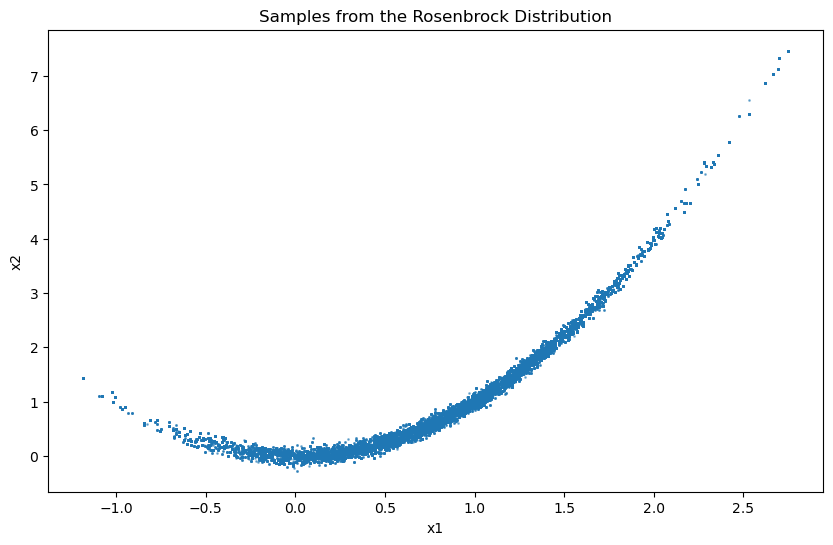

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Rosenbrock function
def rosenbrock(x):
    return sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)

# Transform the Rosenbrock function into a probability density function
def rosenbrock_pdf(x):
    return np.exp(-rosenbrock(x))

# Initialize the Metropolis-Hastings sampler
initial_state = np.zeros(2)  # Start from the origin for simplicity
MH_sampler_RB = MetropolisHastings(target_distr=rosenbrock_pdf, initial_state=initial_state, seed=42)

# Generate 10,000 samples
samples = MH_sampler_RB.sample(50000)

# Print the results
print("Acceptance Rate:", MH_sampler_RB.acceptance_rate)
print("Mean of the Samples:\n", MH_sampler_RB.mean)
print("Covariance Matrix of the Samples:\n", MH_sampler_RB.covariance)
print("Sampling Time:", MH_sampler_RB.time, "seconds")

# Plotting the samples
plt.figure(figsize=(10, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
plt.title("Samples from the Rosenbrock Distribution")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


In [6]:
ac_rb = emcee.autocorr.integrated_time(MH_sampler_RB.samples)
print(ac_rb)


[398.35971025]


r_hat statistik

Time Analysis of Metropolis Hasting

In [ ]:
# Define the target distribution: a multivariate Gaussian for any dimension
def gaussian_target(mean, cov):
    def target(x):
        return scipy.stats.multivariate_normal.pdf(x, mean=mean, cov=cov)
    return target

# Initialize parameters
dimensions = range(1, 21)
n_samples = 10000
times = []

for dim in dimensions:
    mean = np.zeros(dim)
    A = np.random.rand(dim, dim)
    cov = np.dot(A, A.T)
    
    target_distr = gaussian_target(mean, cov)
    initial_state = np.zeros(dim)
    mh_sampler = MetropolisHastings(target_distr=target_distr, initial_state=initial_state, seed=42)
    
    mh_sampler.sample(n_samples)
    times.append(mh_sampler.time)

# Plot the dimensions vs. sampling times
plt.figure(figsize=(10, 6))
plt.plot(dimensions, times, marker='o')
plt.xlabel("Dimension")
plt.ylabel("Sampling Time (seconds)")
plt.title("Metropolis-Hastings Sampling Time vs. Dimension")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define a quadratic function
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# Define the target distribution: a multivariate Gaussian for any dimension
def gaussian_target(mean, cov):
    def target(x):
        return scipy.stats.multivariate_normal.pdf(x, mean=mean, cov=cov)
    return target

# Initialize parameters
dimensions = np.arange(1, 21)  # Use numpy array instead of range
n_samples = 5000
times = []

for dim in dimensions:
    mean = np.zeros(dim)
    A = np.random.rand(dim, dim)
    cov = np.dot(A, A.T)
    
    target_distr = gaussian_target(mean, cov)
    initial_state = np.zeros(dim)
    mh_sampler = MetropolisHastings(target_distr=target_distr, initial_state=initial_state, seed=42)
    
    mh_sampler.sample(n_samples)
    times.append(mh_sampler.time)

# Convert times to numpy array for compatibility with curve_fit
times = np.array(times)

# Fit the quadratic function to the data
popt, _ = curve_fit(quadratic, dimensions, times)

# Generate fitted values
fitted_times = quadratic(dimensions, *popt)

# Plot the original data and the fitted quadratic function
plt.figure(figsize=(10, 6))
plt.plot(dimensions, times, 'o', label='Original Data')
plt.plot(dimensions, fitted_times, '-', label='Fitted Quadratic Function')
plt.xlabel("Dimension")
plt.ylabel("Sampling Time (seconds)")
plt.title("Metropolis-Hastings Sampling Time vs. Dimension with Quadratic Fit")
plt.legend()
plt.grid(True)
plt.show()

# Coefficients of the fitted quadratic function
popt
